# Lab 01 - NLP Methods and Tools Refresher

Goals: The goal of this lab is to provide a refresher on basic NLP methods and standard tools used for NLP research and development. Most of this should have been covered in the Intro to NLP course. As this lab is meant to be a refresher, we won't be diving to deep into any particular topic. If you feel stuck or lost feel free to ask to TA's for assistance. In this lab we'll cover the following:
- Standard data loading and text preprocessing 
- Basic text analysis 
- Basic NLP model development using machine learning and neural language models

## Dataset and NLP Task
For this lab we'll be working Movie Reviews (Hu et Lu 2004, https://www.nltk.org/_modules/nltk/corpus/reader/reviews.html). The dataset consits of 2,000 movie reviews which are labelled as either positive or negative. The data will be loaded into a dataframe with two columns: `text` and `label`. The text column contains the review test and label column either 0 (negative) or 1 (positive). 


## Environment Setup and Data Loading
Before we get started, run the cells below. The first cell will install NLP libraries we'll be using for the lab. Note this cell may take a few minutes to run. The next cell will load nltk into the environment. The last cell will load our toy dataset in the colab enviroment.


In [ ]:
!pip install datasets >> NULL
!pip install transformers >> NULL
!pip install swifter >> NULL
!pip install -U sentence-transformers
!pip install -U scikit-learn >> NULL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6f67538c1257710d695099edd4e8ddbb2b0d984ac44266e7838a5f927e9ef108
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('brown')
nltk.download("movie_reviews")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [ ]:
# Construct dataset for activity
# We'll load movie sentiment datset from nltk into a pandas dataframe for ease of use
from nltk.corpus import movie_reviews
import pandas as pd 
from sklearn.model_selection import train_test_split

pos_ids = movie_reviews.fileids('pos')
neg_ids = movie_reviews.fileids('neg')

pos_reviews = []
for id in pos_ids:
  pos_reviews.append(movie_reviews.raw(fileids=id))

neg_reviews = []
for id in neg_ids:
  neg_reviews.append(movie_reviews.raw(fileids=id))

pos_df = pd.DataFrame({"text": pos_reviews, "label": [1] * len(pos_reviews)})
neg_df = pd.DataFrame({"text": neg_reviews, "label": [0] * len(neg_reviews)})

df = pd.concat([pos_df, neg_df])

train, test = train_test_split(df, random_state=2023, stratify=df["label"], test_size=.20)
train, val = train_test_split(train, random_state=2023, stratify=train["label"], test_size=.15)

print(f"final datasets, train examples: {len(train)}, val examples: {len(val)}, test examples: {len(test)}")

final datasets, train examples: 1360, val examples: 240, test examples: 400


## 1. Preprocessing
Textual data can be messy, especially text scrapped from the web. It can include things like errant markup tags, text encoding symols, social media hashtags and handles, and other noise which would would make both analyzing the text and developing features for traditional ML models difficult. 

Traditional ML model usually focus on using words as features and ignore things like punctuation, symbols, and numbers. For textual analysis, focusing on words and word distribution is also helpful. Ideally, we should strive to generate a constrained but representative vocabulary for our statistical modelling. Simplifing our vocabulary space can be accomplished through standard techniques like lowercasing, dropping stop words (see https://en.wikipedia.org/wiki/Stop_word) and lemmatizing or stemming words (see https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html). 

It's worth noting that modern methods (i.e. Transformer language models) have moved away from some these preprocessing steps as contextual and autoregressive models can model sentence and document level texts. Further, techniques like subword tokenization and byte pair are used to replace token-level vocabularies. However, basic cleaning still helps these models. 

### Exercise 1a: Clean and normalize the text
In this exercise, we create a function which will take unprocessed text string as an input and output cleaned and normalized text string. The method should apply do the following:
1. Lowercase the text
2. Remove all punctuation and numbers

Enure that the returned text is a string. Test your function on the `sample_text` to ensure it is working. 

Given the unprocessed text: `The 3)quick bro*&wn foxes ju#$mped over t<>he l"~azy dogs..`, the method should return `the quick brown foxes jumped over the lazy dogs`.

HINTS: 
- There are many techniques for removing punctuations and numerics from a string. In this the case the simplest way might would be to use a list comprehension over the characters and keep only the character that are part of the alphabhet using python's `isalpha` method (see https://www.w3schools.com/python/ref_string_isalpha.asp). Be sure to account for spaces if you go this route.
- You can create a string a from a list object using the join function for any python string object. A common paradigm is `" ".join(['i', 'like', 'kittens'])` which produce the string `i like kittens.`


In [1]:
def preprocess_text(text: str) -> str:
  """
  Method as as input a messy string and return a clean and normalized string.
  The cleaning process is as follows:
    1. lowercase string
    2. remove all non-alpha characters
  """

  # 1. lowercase the string
  text = text.lower()

  # 2. Strip all non alpha characters  
  text = "".join([char for char in text if char.isalpha() or char == ' '])

  return text

In [ ]:
# Test your function in this cell. Be sure to compile the cell above
messy_text = 'The 3)quick bro*&wn foxes ju#$mped over t<>he l"~azy dogs.'
clean_text = "the quick brown foxes jumped over the lazy dogs"

print(f"Function output: {preprocess_text(messy_text)}")
print(f"Function Test: {preprocess_text(messy_text) == clean_text}")

Function output: the quick brown foxes jumped over the lazy dogs
Function Test: True


### Exercise 1b: Apply preprocessing to corpus

Now that we have a function that cleans and normalizes our text, lets apply it to our corpus. The `train` and `test` environment variables are pandas dataframe objects containing our data. Both dataframes consists of two columns, a `text` column which has the review text and the `label` column with the sentiment label. Create a new column in both the `train` and `test` dataframe called `cleaned_text` which contains the cleaned text. 

Hint:
- Consider using the pandas apply function to apply the `preprocess_text` method to `text` column instead of using a for loop. See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html for more details 

In [ ]:
train["cleaned_text"] = train["text"].apply(preprocess_text)
test["cleaned_text"] = test["text"].apply(preprocess_text)

In [ ]:
for i in range(5):
  display(train["cleaned_text"].iloc[i])
  print('-------------')

'ingredients  man with amnesia who wakes up wanted for murder  dark science fiction city controlled by alien beings with mental powers  synopsis  what if you woke up one day  and suspected you were not on earth  and instead were part of an experiment in a giant space terrarium manipulated by intergalactic alien zookeepers  in dark city john murdoch  rufus sewell  has this problem  dark city starts out like a s noir amnesia detective mystery  poor john wakes up with amnesia in a hotel room with a dead dame in one corner  a mysterious phone call tells him to get the heck out of there  and soon enough john is chased all over town by a murderous army of pale people in black trenchcoats  as well as by the police  and the dogged inspector bumstead  william hurt   is john a murderer  and what can his missing memories tell him  he searches through his own wallet for possible contacts and clues  but when the clues dont fit  it doesnt just confuse him  it causes john to go so far as to question 

-------------


'dont let the following quirks of this review  fool you into believing that this movie is anything short of an ultimate labour of love  but one can see the humour of roberto benigni when you see that  life is beautiful  even though im a short  ugly looking man with an obnoxious laugh  life is beautiful even though i havent amounted to much in life  except working out the finer intricacies of waitering  im a lucky sort of a guy  especially when a beautiful woman strips away my venner of superficiality to find a new age  sensitive guy with the biggest heart in the entire world underneath  life is beautiful  im a jew  but life can still be beautiful  the nazis put me in a concentration camp  but life is still beautiful  i love my son very much and thats what matters  and thats what makes life beautiful  my ability to entertain somehow convinces my son that living in a concentration camp is somewhat beautiful  i get shot for my efforts and the woman i love  but hey thats life and thats sti

-------------


'  you leave little notes on my pillow  i told you a million times i cant stand little notes on my pillow  we are all out of corn flakes  f  u   it took me three hours to figure out that f  u   was felix unger    a frustrated oscar madison  walter matthau  running down a list of his complaints against his roommate felix unger  jack lemmon   in the odd couple  the classic neil simon comedy  based on his own stage play  about suicidal felix  lemmon   who is persuaded by his poker friend oscar  matthau  to stay with him in his apartment after felixs wife throws him out and files for divorce  the hook  oscar is messy and likes his apartment that way  while felix is an obsessivecompulsive neat freak  the two men  despite their friendship  instantly clash  movies just arent as delightfully funny as this one is  every line of neil simons dialogue flows like comedic poetry  and all the actors are just perfect in their performances  lemmon is at his best as the anxiety ridden felix  but its mat

-------------


'my fellow americans is a movie that at first glance looks to have little substance  or a movie that weve all seen a million times   two lifetime rivals thrown together and then the fun begins  this is exactly what happened in this movie  but fortunately  they managed to do it in an interesting and funny way  the movie starts with a quick  and i do mean quick  glance of two presidents russell kramer  jack lemmon  and matt douglas  james garner   william haney  dan aykroyd  and ted matthews  john heard  are the new president and vice president  there is a scandal that arises involving a kickback from a contractor and haney is positive that he buried that years ago  he finds a scapegoat in kramer and now everyone wants kramer and douglas dead  this movie was exceptional for many reasons  one being that they found people  lemmon and garner  that have good chemisty together  they worked very well as a unit and they mirrored each other perfectly  one being a ladies man and one being the old

-------------


'did claus von bulow try to kill his wife sunny in their newport mansion  that is the question reversal of fortune asks you to consider as it opens in a hospital ward  with a comatose sunny von bulow  she is the main narrator of the film  in a narrative trick that was extraordinarily risky for schroeder  the dramatic trick works  as sunny von bulow narrates a compelling story of murder  sex  unhappiness  and a lawyers moral dilemma as he takes a case he thinks he cannot win  jeremy irons is claus von bulow  in what is his finest role  and one of the most devastingly evil performances in history  he is as hated as any man alive  as cold as a cucumber  his remorse for his wifes comatose condition is nonexistant  and it is no wonder that even his children have difficulty accepting his version of what happened during christmas    the background to the case is such  during christmas of   sunny von bulow fell into a deep coma from which she recovered and awoke  the same situation occured in 

-------------


## Lemmatize text

In order to standardize our vocabulary we'll lemmatize our texts. We'll use NLTK library for lemmatization. To improve the performance of the NLTK lemmatizer, we will also use the POS tags. Note it may take 1-3 minutes to run.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(text):
    return " ".join(lemmatizer.lemmatize(tok) for tok in text.split())

train["cleaned_text"] = train["cleaned_text"].apply(lemmatize_sentence)
test["cleaned_text"] = test["cleaned_text"].apply(lemmatize_sentence)

In [ ]:
train["cleaned_text"][0]

'film adapted from comic book have had plenty of success whether theyre about superheroes batman superman spawn or geared toward kid casper or the arthouse crowd ghost world but there never really been a comic book like from hell before for starter it wa created by alan moore and eddie campbell who brought the medium to a whole new level in the mid s with a part series called the watchman to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd the book or graphic novel if you will is over page long and includes nearly more that consist of nothing but footnote in other word dont dismiss this film because of it source if you can get past the whole comic book thing you might find another stumbling block in from hell director albert and allen hughes getting the hughes brother to direct this seems almost a ludicrous a casting carrot top in well anything but riddle me this who better to direct a film

## 2. Textual Analysis

Before jumping into creating a model, it's usually a good idea to analyze your corpus. For our task, let's take a look the language usage between positive and negative reviews. Our intuition tells us that word distibutions will differ across the positive and negative reviews. To validate let's analyze the text further.

### Exercise 2a. Distribution of words and ngrams per label
Let's see if we can identify the top 25 words/bigrams for the positive and negative labels. To accomplish this, we will have to compute the frequencies for all the unique words and bigrams across all the reviews per label. Keep in mind you may find if you consider all words equally, uninformative words like (a, the, is, etc) will likely appear at the top. You should account for stop words and consider what types of words might be the most useful. 

As a reminder, when looking at the labels column, 0 denote negative reviews and 1 positive reviews. Only use the train dataset for this exercise to preserve the test distribution.

Hint:
- You can generate bigrams using the nltk bigrams function (https://www.tutorialspoint.com/python_text_processing/python_bigrams.htm)
- You may have to manually create a list of corpus level stopwords, i.e. words specific to the movie domain which are frequently occurring in context of reviews but has limited value for predicting the positive reviews. You can also consider building a vocabulary using the TFIDF or Count vectorizer from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- For computing frequencies consider using the `Counter` method from the collection library (https://docs.python.org/3/library/collections.html#collections.Counter) can be useful
- Consider narrowing down your vocabulary to specific POS tags like nouns and adjectives
- You can get the list of NLTK stopwords with the code below:
```
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))
```

In [2]:
# Generate Frequencies for the positive labels 
import nltk
import numpy as np 

positive_examples = train.query("label == 1")["cleaned_text"].tolist()
cv = CountVectorizer(stop_words="english", ngram_range=(1,3), max_df=.6)
cv.fit(positive_examples)

id2vocab = {v:k for k,v in cv.vocabulary_.items()}

pos_matrix = cv.transform(positive_examples)
counts = np.array(np.sum(pos_matrix, axis=0))[0]
sorted_mat = np.argsort(counts)[::-1]

# Top 15 tokens
for val in sorted_mat[:25]:
  print(f"{id2vocab[val]}: {counts[val]}")

NameError: ignored

In [ ]:
# Generate Frequencies for the negative labels 
import nltk
import numpy as np 

negative_examples = train.query("label == 0")["cleaned_text"].tolist()
cv = CountVectorizer(stop_words="english", ngram_range=(1,3), max_df=.6)
cv.fit(negative_examples)

id2vocab = {v:k for k,v in cv.vocabulary_.items()}

neg_matrix = cv.transform(negative_examples)
counts = np.array(np.sum(neg_matrix, axis=0))[0]
sorted_mat = np.argsort(counts)[::-1]

# Top 15 tokens
for val in sorted_mat[:25]:
  print(f"{id2vocab[val]}: {counts[val]}")

scene: 885
good: 775
story: 687
bad: 655
plot: 572
thing: 572
way: 562
really: 555
know: 529
come: 486
look: 486
year: 478
doe: 475
dont: 472
little: 464
people: 450
doesnt: 450
end: 434
director: 434
work: 431
action: 428
actor: 413
life: 409
man: 408
play: 404


## 3. Machine Learning Models with bag of words features

In this section we'll explore traditional ML models for our sentiment analysis task. We can frame the sentiment analysis as binary classification task where the goal is to predict a positive or negative label given a review. Since the models can't interact directly with the text itself, we need to a way to represent the text of the reviews numerically for the models. One way to do this is to treat the text a bag of words. Given a fixed vocabulary, we provide the model a count of the tokens that appear in the input text. We can use the `CountVectorizier` or `TfidfVectorizer` from the `scikit-learn` library to generate a vocabulary and transform the text into a numerical and vectorized format for the models.



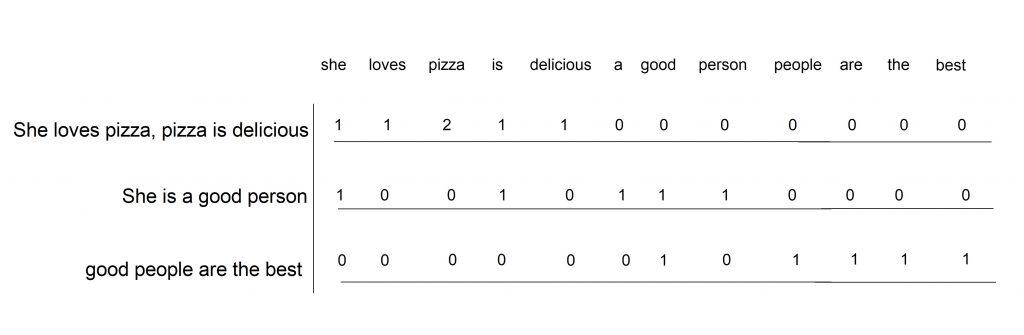


## Exercise 3a: Beat the Naive Baseline

For this exercise, the goal is produce a model that outperforms the our baseline. The `scikit-learn` library (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) provides implementation for some of the most widely used machine learning models and a simple API for training the models. 


The code below will walk you through how to generate input features using the `TfidfVectorizer` (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and train a Naive Gaussian Bayes model. We recommend you fix the vocabulary size (using `max_features` argument) to value under 50k to ensure that you don't run into memory issues. 

After you have reviewed the baseline code, experiment with the various models in the `scikit-learn` library and try to identify a model which outperforms the results of the baseline model below. 


*Bonus Challenge: Best our Best Model*

Below is the classfiication report for our best model. See if you can produce a model which either matches or outperforms our model. Please stick with models available in the `scikit-learn` library as the next section will explore modern deep learning / neural language models. Our model uses the same features as the Naive GB baseline and we did not do any hyper-parameter tuning. Feel to explore using different input features, hyper parameter tuning, cross-validation or other strategies that might able to outperform our model. 

```
                 precision   recall  f1-score   support

           0       0.85      0.88      0.86       200
           1       0.87      0.84      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400
```


Hints
- Consider the format of the task (binary classification) and see if there is a model that better suited for that task.
- Consider hyperparameter tuning using the cross-validation and gridsearch (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 

In [ ]:
# Generate Input Features
from sklearn.feature_extraction.text import TfidfVectorizer

# We'll use the TFIDF instead of pure counts as it provides the model additional
# information.
tfidf = TfidfVectorizer(
    stop_words="english", # use english stopwords
    ngram_range=(1,3),    # generate ngrams 
    max_df=.6,            # corpus level stopwords: words that frequently occur in corpus
    max_features=20000    # maximum vocabulary size
)

# Fit the tfidf vectorizer on the cleaned text column
tfidf.fit(train["cleaned_text"])

# Generate feature for train
train_X = tfidf.transform(train["cleaned_text"])
train_y = train["label"].tolist()                # labels are already numericalized 


# Generate features for test
test_X = tfidf.transform(test["cleaned_text"])
test_y = test["label"].tolist()

train_X.shape

(1360, 20000)

In [ ]:
# Train a Gaussian Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

nb = GaussianNB()                    # Initialize Model
nb.fit(train_X.toarray(), train_y)   # Fit model to train inputs and labels. 

preds = nb.predict(test_X.toarray())   # Generate Predictions 

print(classification_report(test_y, preds))  # Generate Classification Report

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       200
           1       0.65      0.72      0.69       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



In [ ]:
# Your Code HERE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(train_X.toarray(), train_y)

preds = lr.predict(test_X.toarray())

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       200
           1       0.83      0.84      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_X.toarray(), train_y)

preds = rf.predict(test_X.toarray())

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79       200
           1       0.83      0.67      0.74       200

    accuracy                           0.77       400
   macro avg       0.78      0.77      0.77       400
weighted avg       0.78      0.77      0.77       400



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(early_stopping=True)
mlp.fit(train_X.toarray(), train_y)

preds = mlp.predict(test_X.toarray())

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       200
           1       0.84      0.84      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [ ]:
from sklearn.ensemble import VotingClassifier


mlp = MLPClassifier(early_stopping=True)
rf = RandomForestClassifier()
lr = LogisticRegression()

ensemble = VotingClassifier(
    estimators=[ 
        ('lr', lr),   # logistic regression
        ('rf', rf),   # random forest
        ('mlp', mlp)  # multilayer perceptron
    ], 
    voting="soft"
)
ensemble.fit(train_X.toarray(), train_y)


preds = ensemble.predict(test_X.toarray())

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       200
           1       0.87      0.84      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



## 4. NLP w/ Transformer Language Models 

For the final part of the lab, we will explore using neural language models. Modern language models (BERT, ERNIE, GPT, T5, etc) have been found to be very effective across a wide range of NLP tasks. These models are usually deep neural networds which have been pretrained on large text corpora (i.e. Wikipedia, Common Crawl, BooksCorpus, etc) and are able to learn about the various aspects of language (syntax, grammar, semantics, etc) which can be tranferred acroos various domains and NLP tasks. The Transformer architecture (https://jalammar.github.io/illustrated-transformer/) tends to be the backbone for most modern language models. We sort the transformer models into two categories: autoregressive models and autencoding models. Autoregressive models (e.g. GPT, XLNet) are pretrained on the next word prediction. Given a sequence (the cat sat on the [BLANK]), the model attempts to predict the likely next word the sequence. In contrast autoencoding models (BERT, T5, RoBERTa, ERNIE) are trained to reconstruct corrupted sequences. So a given sentence like the cat sat on the mat would be corrupted by masking a random set of words, e.g. the [MASK] sat on the [MASK], where model must predict the masked tokens. Unlike autoregressive pretraining, the model uses the context of the full input to understand its masked constituent parts. 

There are two ways to use to these models given an arbitrary task. The weights of the model can be frozen and the last hidden layer output of the model can be used as a set of fixed features. While the method is very quick, it is limited in its efficacy. The other ways is finetuning. Finetuning is the process of updating the pretrained weights in order to adapt the model to a new task and domain (e.g. sentiment classification). Since the model already has internalized its own understanding of language, grammar, and semantics, finetuning usually only takes 1-5 epochs of additional gradient updates to condition the model to support the new task. 


The `HuggingFace` library hosts implementations and trained weights for nearly all the cutting edge Transformer models and has a unified and easy to use API for finetuning these models. For the final part of the lab we'll walk through how to prepare data for finetuning and train a model for our sentiment task. 

We'll explore finetuning the DistilBERT (https://arxiv.org/abs/1910.01108) model for the last section. DistilBERT reduces the size of BERT model (fewer parameters and hidden layers) which allows for quicker finetuning while still retaining 90% of BERT's performance. For all other consideritions (input encoding, training, etc) DistilBERT is identical to BERT. We recommend for this section to change your runtime type to GPU as it will dramatically speed up training time. You may find you'll need to rerun earlier cells to ensure the dataset is reloaded into memory. 

### 4.1 Data Preparation

DistilBERT expects wordpiece ids as input. Wordpiece is subword (https://huggingface.co/course/chapter6/6?fw=pt) tokenization algorithm learns a fixed set of token and partial token units which can be used to construct any word. The `AutoTokenizer` class from can be used to load the BERT wordpiece vocabulary and automatically enocde any text to a sequence of wordpiece ids. Let's explore this a bit further below.


In [ ]:
# Import Autokenizer method from transformers
from transformers import AutoTokenizer

# Load DistilBert vocabulary using the .from_pretrained method
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Encoding a sentence
sent = "The quick brown fox jumped over the lazy dog."
print(f"Tokenizer output a dictionary: {tokenizer(sent)}")

# We can also decode ids to vocabulary
print(tokenizer.decode([101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 1012, 102]))

Tokenizer output a dictionary: {'input_ids': [101, 1996, 4248, 2829, 4419, 5598, 2058, 1996, 13971, 3899, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS] the quick brown fox jumped over the lazy dog. [SEP]


Next we need to create a custom Pytorch Dataset class to store the the generated encodings for our train corpus. The code below creates a custom class and generates the datasets for the train, val, and test sets.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch

# Define Custom Class for DistilBert Inputs
class SentimentDataset(Dataset):
    
    def __init__(self, encodings: dict):  
        self.encodings = encodings
        
    def __len__(self) -> int:
        return len(self.encodings["input_ids"])
    
    def __getitem__(self, idx: int) -> dict:
        e = {k: v[idx] for k,v in self.encodings.items()}
        return e 

# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


# Train Inputs
train_encodings = tokenizer(
    train["text"].tolist(), 
    padding=True,           # pad all inputs to max length
    max_length=128,         # Bert max is 512, we choose 128 due to compute limitations
    return_tensors="pt",    # Return format pytorch tensor
    truncation=True
)
train_encodings["labels"] = torch.tensor(train["label"].tolist())  # Update train inputs with labels 
train_dataset = SentimentDataset(train_encodings)

# Val Inputs
val_encodings = tokenizer(
    val["text"].tolist(), 
    padding=True,           # pad all inputs to max length
    max_length=128,         # Bert max is 512, we choose 128 due to compute limitations
    return_tensors="pt",     # Return format pytorch tensor
    truncation=True
)
val_encodings["labels"] = torch.tensor(val["label"].tolist())  # Update train inputs with labels 
val_dataset = SentimentDataset(val_encodings)


# Test Inputs 
test_encodings = tokenizer(
    test["text"].tolist(), 
    padding=True,           # pad all inputs to max length
    max_length=128,         # Bert max is 512, we choose 128 due to compute limitations
    return_tensors="pt",     # Return format pytorch tensor
    truncation=True
)
test_y = test["label"].tolist()
test_dataset = SentimentDataset(test_encodings)

In [ ]:
# Lets take a look at whats in the train dataset
display(train_dataset[:2])

{'input_ids': tensor([[  101, 12760,  1024,  2158,  2007, 29222,  2040, 17507,  2039,  2359,
           2005,  4028,  1010,  2601,  2671,  4349,  2103,  4758,  2011,  7344,
           9552,  2007,  5177,  4204,  1012, 19962, 22599,  1024,  2054,  2065,
           2017,  8271,  2039,  2028,  2154,  1010,  1998,  6878,  2017,  2020,
           2025,  2006,  3011,  1010,  1998,  2612,  2020,  2112,  1997,  2019,
           7551,  1999,  1037,  5016,  2686, 14403, 18802, 20063,  2011,  6970,
           9692, 28804,  7344,  9201, 24764,  1029,  1999,  2601,  2103,  2198,
          19954,  1006, 18316,  7367,  4381,  1007,  2038,  2023,  3291,  1012,
           2601,  2103,  4627,  2041,  2066,  1037,  7675, 15587, 29222,  6317,
           6547,  1012,  3532,  2198, 17507,  2039,  2007, 29222,  1999,  1037,
           3309,  2282,  2007,  1037,  2757,  8214,  1999,  2028,  3420,  1012,
           1037,  8075,  3042,  2655,  4136,  2032,  2000,  2131,  1996, 17752,
           2041,  1997,  20

## 4.2 Model Training
HuggingFace makes it simple to finetune transformer models for any task. First we load the pretrained model. `AutoModelForSequenceClassification` is a generic class combines an language model encoder with a classification head. Next create a `TrainingArgs` object which contains the training configuration details. Finally we create a `Trainer` object which will handle all the requisite training steps (i.e. learning rate scheduling, gradient backprop, etc). 

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments


model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    lr_scheduler_type='cosine',
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32, 
    fp16=True,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

Epoch,Training Loss,Validation Loss
1,No log,0.671083
2,No log,0.603685
3,No log,0.590941


***** Running Evaluation *****
  Num examples = 240
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-43
Configuration saved in ./results/checkpoint-43/config.json
Model weights saved in ./results/checkpoint-43/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 240
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-86
Configuration saved in ./results/checkpoint-86/config.json
Model weights saved in ./results/checkpoint-86/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 240
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-129
Configuration saved in ./results/checkpoint-129/config.json
Model weights saved in ./results/checkpoint-129/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=129, training_loss=0.5324779185213784, metrics={'train_runtime': 27.3341, 'train_samples_per_second': 149.264, 'train_steps_per_second': 4.719, 'total_flos': 135116746629120.0, 'train_loss': 0.5324779185213784, 'epoch': 3.0})

Now that our model is trained, we can generate prediction.

In [ ]:
preds = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 400
  Batch size = 32


Finally we can evaluate our model. We are able to achieve 100% accuracy on our test!

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds[1].tolist()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

